In [1]:
import warnings
warnings.filterwarnings("ignore") 
from IPython.core.display import display, HTML

import time

import numpy as np
from numpy import matlib
import tensorflow as tf

from sklearn.cluster import KMeans
import scipy

from sklearn.datasets import make_moons

import matplotlib as mpl
import matplotlib.pyplot as plt

Explorando dados

(100000, 2)


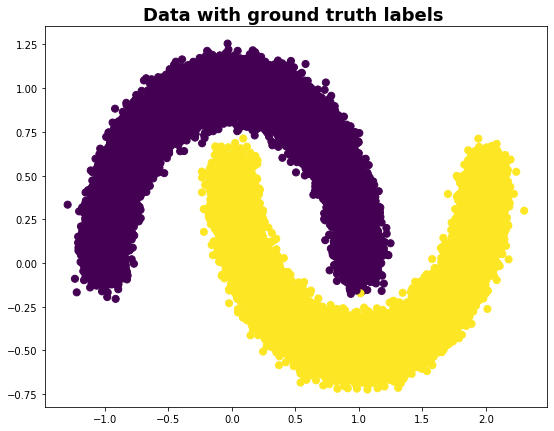

In [2]:
random_state = 21
X_mn, y_mn = make_moons(100000, noise=.07, random_state=random_state)
print(X_mn.shape)
cmap = 'viridis'
dot_size=50

fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data with ground truth labels ', fontsize=18, fontweight='demi')

ax.scatter(X_mn[:, 0], X_mn[:, 1],c=y_mn,s=dot_size, cmap=cmap)

## Passo 1
### Hybrid Representative Selection

In [3]:
def getRepresentivesByRandomSelection(data, pSize):
		N = data.shape[0]
		if pSize > N:
			pSize = N
		
		selectIdx = np.random.permutation(np.arange(N))[:pSize]
		randSelect = []
		for i in selectIdx:
			randSelect.append(data[i,:])

		return np.array(randSelect)
    
def getRepresentativesByHybridSelection(data, pSize, cntTimes=10):
		N = data.shape[0]
		bigPSize = cntTimes * pSize
		
		if pSize > N: 
			pSize = N
		if bigPSize > N: 
			bigPSize = N

		#random selection
		np.random.seed(int(time.time()))
		RpBigPdata = getRepresentivesByRandomSelection(data, bigPSize)
		
		#KNN selection
		RpData = KMeans(n_clusters=pSize, max_iter=cntTimes).fit(RpBigPdata)
		
		return RpData

In [4]:
N_representations = 1000

In [5]:
RpData = getRepresentativesByHybridSelection(X_mn, N_representations)

In [6]:
RpData.cluster_centers_

array([[ 0.03875231, -0.03189941],
       [ 1.76662161, -0.14583774],
       [-0.47042711,  0.83954726],
       ...,
       [ 1.75255445, -0.19675746],
       [ 0.04448502,  0.56300693],
       [-0.02820297,  0.95492411]])

## Passo 2
### Approximation of K-Nearest Representatives

In [7]:
N = X_mn.shape[0]

In [8]:
cntRepCls = int(np.floor(np.sqrt(RpData.cluster_centers_.shape[0])))
print(cntRepCls)
AprData = KMeans(n_clusters=cntRepCls, max_iter=600).fit(RpData.cluster_centers_)

31


In [9]:
AprData.labels_.shape

(1000,)

In [10]:
AprData.cluster_centers_

array([[ 1.86062929,  0.01291996],
       [ 0.08031679,  0.06375422],
       [-0.42607235,  0.90190167],
       [ 0.66565718,  0.74953571],
       [-0.94529565,  0.35938886],
       [ 0.68806171, -0.48110949],
       [ 1.11595573, -0.3958632 ],
       [ 0.32450576, -0.31729191],
       [ 0.82813971,  0.581858  ],
       [ 1.96565072,  0.20789507],
       [ 0.24182464,  0.95881399],
       [-0.00794007,  0.4684708 ],
       [-0.6399727 ,  0.77563654],
       [ 1.48708549, -0.47155442],
       [ 0.93340088,  0.39325481],
       [ 0.02063122,  1.02762086],
       [ 1.19563455, -0.54034186],
       [ 1.76930058, -0.16749352],
       [-1.00204078,  0.07756964],
       [ 1.97308909,  0.44687938],
       [ 1.60063115, -0.27595323],
       [ 0.91702966, -0.50518987],
       [ 0.47146711,  0.90002092],
       [ 0.22716806, -0.11064001],
       [-0.79325184,  0.58179095],
       [ 1.37508697, -0.37033931],
       [ 0.51466085, -0.34587864],
       [ 0.96880927, -0.01052312],
       [ 1.00363502,

In [11]:
Features = tf.constant(X_mn, dtype=tf.float32)
Apr_centers = tf.constant(AprData.cluster_centers_, dtype=tf.float32)

In [12]:
def dist_tf(A, B):
    return tf.sqrt(-2 * 
    tf.matmul(A, B, transpose_b=True) + 
    tf.reduce_sum(tf.square(B), axis=1) +
    tf.expand_dims(tf.reduce_sum(tf.square(A), axis=1), axis=1))

In [13]:
minCenterIdxs = tf.math.argmin(dist_tf(Features, Apr_centers), axis=1)
del Apr_centers

minCenterIdxs.shape

TensorShape([100000])

In [14]:
Apr_labels = tf.constant(AprData.labels_)
RpData_centers = tf.constant(RpData.cluster_centers_, dtype=tf.float32)

In [15]:
nearestRepInRpFeaIdx = tf.zeros([N], dtype=tf.int64)
for i in range(cntRepCls):
    originalIdxs = tf.where(minCenterIdxs == i)
    aprDataIdxs = tf.where(Apr_labels == i)

    # originalTemp = np.take(Features, originalIdxs).ravel()
    originalTemp = tf.gather_nd(Features, originalIdxs)
    # aprDataTemp = np.take(RpData.cluster_centers_, aprDataIdxs).ravel()
    aprDataTemp = tf.gather_nd(RpData_centers, aprDataIdxs)

    temp = dist_tf(originalTemp, aprDataTemp)

    tempMin = tf.math.argmin(temp, axis=1) 

    update = tf.squeeze(tf.gather(aprDataIdxs, tempMin)) 

    nearestRepInRpFeaIdx = tf.tensor_scatter_nd_update(nearestRepInRpFeaIdx, originalIdxs, update)

del AprData, Apr_labels, update, tempMin, aprDataIdxs, aprDataTemp, minCenterIdxs

In [16]:
Knn = 10
neighSize = 10*Knn

In [17]:
RpFeaW = dist_tf(RpData_centers, RpData_centers)

RpFeaKnnIdx = tf.argsort(RpFeaW, axis=1)

del RpFeaW

RpFeaKnnIdx = RpFeaKnnIdx[:,:int(neighSize)]

RpFeaKnnDist = tf.zeros([N, RpFeaKnnIdx.get_shape().as_list()[1]]);

for i in range(N_representations):
    originalIdxs = tf.where(nearestRepInRpFeaIdx == i)
    originalTemp = tf.gather_nd(Features, originalIdxs)
    RpFeatTemp = tf.gather(RpData_centers, RpFeaKnnIdx[i])

    temp = dist_tf(originalTemp, RpFeatTemp)

    RpFeaKnnDist = tf.tensor_scatter_nd_update(RpFeaKnnDist, originalIdxs, temp)

del RpData, originalIdxs, originalTemp, RpFeatTemp, temp, Features, RpData_centers

RpFeaKnnDist

<tf.Tensor: shape=(100000, 100), dtype=float32, numpy=
array([[0.02813873, 0.04652913, 0.04683429, ..., 0.32467765, 0.35964525,
        0.3545211 ],
       [0.01881784, 0.04621808, 0.04695314, ..., 0.3508785 , 0.32212633,
        0.35680833],
       [0.01894569, 0.04404422, 0.06041679, ..., 0.31883645, 0.31470492,
        0.34573865],
       ...,
       [0.03890349, 0.02892628, 0.06339952, ..., 0.2988314 , 0.3452479 ,
        0.37339327],
       [0.02658892, 0.06460138, 0.06454784, ..., 0.36278844, 0.37456018,
        0.35432678],
       [0.0051905 , 0.04035047, 0.03454051, ..., 0.33433932, 0.32539174,
        0.3348586 ]], dtype=float32)>

In [18]:
RpFeaKnnIdxFull = tf.gather(RpFeaKnnIdx, nearestRepInRpFeaIdx)
del RpFeaKnnIdx, nearestRepInRpFeaIdx

RpFeaKnnIdxFull.shape

TensorShape([100000, 100])

In [19]:
knnDist = tf.zeros([N, Knn])
knnIdx = tf.zeros([N, Knn], dtype=tf.int32)

for i in range(Knn):
    idx = tf.math.argmin(RpFeaKnnDist, axis=1)
    minV = tf.reduce_min(RpFeaKnnDist, axis=1)
    idx_R = tf.range(0, limit=N, dtype=tf.int64)
    temp = (idx * N) + idx_R
    col = tf.expand_dims(tf.zeros([N], dtype=tf.int64)+i, axis=1)
    idx_R = tf.concat([tf.expand_dims(idx_R, axis=1), col], axis=1)

    knnDist = tf.tensor_scatter_nd_update(knnDist, idx_R, minV)
    # knnDist [:, i] = minV

    knnIdx = tf.tensor_scatter_nd_update(knnIdx, idx_R, RpFeaKnnIdxFull[:,i])

    temp = tf.where(temp<N, np.inf, RpFeaKnnDist[:,i])
    RpFeaKnnDist = tf.tensor_scatter_nd_update(RpFeaKnnDist, idx_R, temp)
    # for j in range(len(temp)):

    # 	knnIdx[j, i] = RpFeaKnnIdxFull[j, i]

    # 	if(temp[j] < N):
    # 		RpFeaKnnDist[j, i] = np.inf

del RpFeaKnnDist, RpFeaKnnIdxFull, idx, minV, idx_R, temp, col
print(knnDist)

tf.Tensor(
[[0.02813873 0.02838548 0.02838548 ... 0.02838548 0.02838548 0.02838548]
 [0.01881784 0.03010364 0.03010364 ... 0.03010364 0.03010364 0.03010364]
 [0.01894569 0.0306433  0.0306433  ... 0.0306433  0.0306433  0.0306433 ]
 ...
 [0.02892628 0.02892628 0.02892628 ... 0.02892628 0.02892628 0.02892628]
 [0.02658892 0.04056042 0.04056042 ... 0.04056042 0.04056042 0.04056042]
 [0.0051905  0.03454051 0.03454051 ... 0.03454051 0.03454051 0.03454051]], shape=(100000, 10), dtype=float32)


In [20]:
knnMeanDiff = tf.reduce_mean(knnDist)
Gsdx = tf.math.exp(-(tf.square(knnDist)/2*tf.square(knnMeanDiff)))
print(Gsdx)
del knnDist, knnMeanDiff

tf.Tensor(
[[0.99999964 0.99999964 0.99999964 ... 0.99999964 0.99999964 0.99999964]
 [0.9999999  0.9999995  0.9999995  ... 0.9999995  0.9999995  0.9999995 ]
 [0.99999976 0.9999995  0.9999995  ... 0.9999995  0.9999995  0.9999995 ]
 ...
 [0.99999964 0.99999964 0.99999964 ... 0.99999964 0.99999964 0.99999964]
 [0.9999997  0.9999992  0.9999992  ... 0.9999992  0.9999992  0.9999992 ]
 [1.         0.99999946 0.99999946 ... 0.99999946 0.99999946 0.99999946]], shape=(100000, 10), dtype=float32)


In [21]:
Gsdx = tf.where(Gsdx == 0.0, np.finfo(np.float32).eps, Gsdx)

In [22]:
Gidx = tf.expand_dims(tf.reshape(tf.constant(matlib.repmat(np.arange(N), Knn, 1).T), shape=[N*Knn]), axis=1)
Gidx = tf.concat([Gidx, tf.expand_dims(tf.reshape(knnIdx,  shape=[N*Knn]), axis=1)], axis=1)
Gidx

<tf.Tensor: shape=(1000000, 2), dtype=int32, numpy=
array([[    0,   933],
       [    0,   194],
       [    0,   775],
       ...,
       [99999,   446],
       [99999,   850],
       [99999,   888]])>

In [23]:
B = tf.sparse.SparseTensor(tf.cast(Gidx, dtype=tf.int64), tf.reshape(Gsdx,  shape=[N*Knn]), [N, N_representations])
B = tf.sparse.reorder(B)
del Gsdx, Gidx, knnIdx

## Passo 3
### Bipartite Graph Partitioning

In [24]:
print(B)

SparseTensor(indices=tf.Tensor(
[[    0   933]
 [    0   194]
 [    0   775]
 ...
 [99999   446]
 [99999   850]
 [99999   888]], shape=(1000000, 2), dtype=int64), values=tf.Tensor([0.99999964 0.99999964 0.99999964 ... 0.99999946 0.99999946 0.99999946], shape=(1000000,), dtype=float32), dense_shape=tf.Tensor([100000   1000], shape=(2,), dtype=int64))


In [25]:
dx = tf.sparse.reduce_sum(B, axis=1)
dx = 1/dx
dx = tf.where(tf.math.is_nan(dx), 0, dx)
idx = tf.expand_dims(tf.range(0, limit=N, dtype=tf.int64), axis=1) 
Dx = tf.sparse.SparseTensor(tf.concat([idx, idx], axis=1), dx, [N, N])
del idx

In [26]:
aux_v = matlib.repmat(dx.numpy(), Knn, 1).T.ravel()
aux_v = B.values * aux_v
aux = tf.sparse.SparseTensor(B.indices, aux_v, [N, N_representations])

del aux_v

aux = tf.sparse.transpose(aux)
B = tf.sparse.to_dense(B)
Er = tf.sparse.sparse_dense_matmul(aux, B)
Er

<tf.Tensor: shape=(1000, 1000), dtype=float32, numpy=
array([[ 61.59962 ,   0.      ,   0.      , ...,   0.      ,   0.      ,
          0.      ],
       [  0.      , 129.09868 ,   0.      , ...,  59.599663,   0.      ,
          0.      ],
       [  0.      ,   0.      , 143.99959 , ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [  0.      ,  59.599663,   0.      , ..., 135.49907 ,   0.      ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,  39.19994 ,
          0.      ],
       [  0.      ,   0.      ,   0.      , ...,   0.      ,   0.      ,
        131.69882 ]], dtype=float32)>

In [27]:
d = tf.math.reduce_sum(Er, axis=1)
d = 1/tf.math.sqrt(d)
idx = tf.expand_dims(tf.range(0, limit=N_representations, dtype=tf.int64), axis=1) 
D = tf.sparse.SparseTensor(tf.concat([idx, idx], axis=1), d, [N_representations, N_representations])
# D = np.zeros((N_representations, N_representations))
# np.fill_diagonal(D, d)
del d, idx

In [28]:
Dr = tf.sparse.sparse_dense_matmul(tf.sparse.sparse_dense_matmul(D, Er), D)
Dr = (Dr + tf.transpose(Dr))/2

In [29]:
aval, avec = tf.linalg.eig(Dr)
del Dr, Er

In [30]:
N_clusters = 2

In [31]:
idx = tf.argsort(tf.math.real(aval), direction='DESCENDING').numpy()[:N_clusters]
avec = tf.gather(tf.math.real(avec), idx, axis=1)
Ncut_avec =	tf.sparse.sparse_dense_matmul(D, avec)

In [32]:
res = tf.matmul(tf.sparse.sparse_dense_matmul(Dx, B), Ncut_avec)

In [33]:
del Dx, idx, D, B, Ncut_avec, aval, avec
res.shape

TensorShape([100000, 2])

In [34]:
norm = (tf.math.sqrt(tf.math.reduce_sum(res*res, axis=1)) + 1e-10)
norm = tf.expand_dims(norm, axis=1)
norm = tf.concat([norm, norm], axis=1)
res = res/norm
del norm

In [35]:
res

<tf.Tensor: shape=(100000, 2), dtype=float32, numpy=
array([[ 0.7019543 ,  0.71222186],
       [ 0.7123301 ,  0.7018445 ],
       [ 0.7083655 ,  0.70584565],
       ...,
       [ 0.71869844, -0.6953218 ],
       [ 0.7163751 , -0.6977152 ],
       [ 0.69431764, -0.71966845]], dtype=float32)>

In [36]:
res = res.numpy()

In [37]:
K =  KMeans(n_clusters=N_clusters).fit(res)

In [38]:
pred = K.labels_

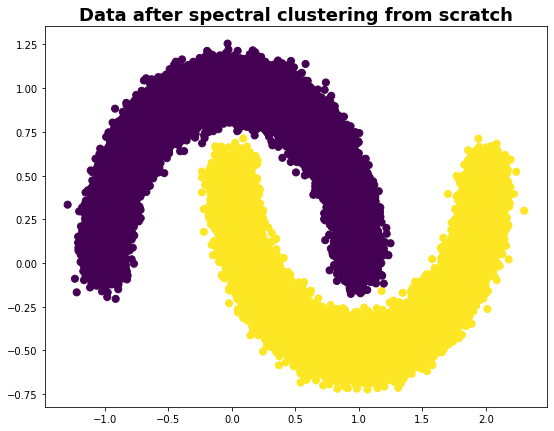

In [39]:
fig, ax = plt.subplots(figsize=(9,7))
ax.set_title('Data after spectral clustering from scratch', fontsize=18, fontweight='demi')
ax.scatter(X_mn[:, 0], X_mn[:, 1],c=pred,s=dot_size, cmap=cmap)